In [14]:
import sys
sys.path.append('../../')

In [15]:
from scripts.utils import data_path, set_mpl, read_hamelin, add_datetime_features, read_london, read_trentino
from scripts.calendar import timeanddate_calendar
from scripts.google_trends import download_google_trends

In [21]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import os
import tqdm
import requests
from datetime import datetime, timedelta
import time

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb
%matplotlib widget

from pytrends.request import TrendReq

In [17]:
london_std, london_tou, london_weather, london_twitter = read_london()


    Loading London data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Weather from `meteostat` package.

    STD and ToU tariffs are separated.
    Data resampled (mean) to 1H resolution from original 30min resolution.

    reutrns:
    df_std: pd.DataFrame with STD tariff data
    df_tou: pd.DataFrame with ToU tariff data
    df_weather: pd.DataFrame with weather data
    df_twitter: pd.DataFrame with twitter data (see `0_data/2.2_london_twitter.ipynb` for details)
    
    


In [18]:
df_holiday = timeanddate_calendar(geo_id='uk',start_year=2011,end_year=2015+1)
df_holiday

,date,holiday_Name,holiday_Type
0,2011-01-01,weekend,weekend
1,2011-01-02,weekend,weekend
2,2011-01-03,New Year's Day observed,Bank Holiday
3,2011-01-04,2nd January (substitute day),Local Bank Holiday
4,2011-01-05,weekday,weekday
...,...,...,...
2183,2016-12-23,weekday,weekday
2184,2016-12-24,weekend,weekend
2185,2016-12-25,weekend,weekend
2186,2016-12-26,Boxing Day,Bank Holiday


In [19]:
df_holiday_encode = df_holiday.copy()
df_holiday_encode[['holiday_Name', 'holiday_Type']] = df_holiday_encode[['holiday_Name', 'holiday_Type']].astype('str').apply(preprocessing.LabelEncoder().fit_transform)
df_holiday_encode.columns = df_holiday_encode.columns+'_encode'
df_holiday_encode = df_holiday_encode.rename(columns={'date_encode':'date'})

### TOU

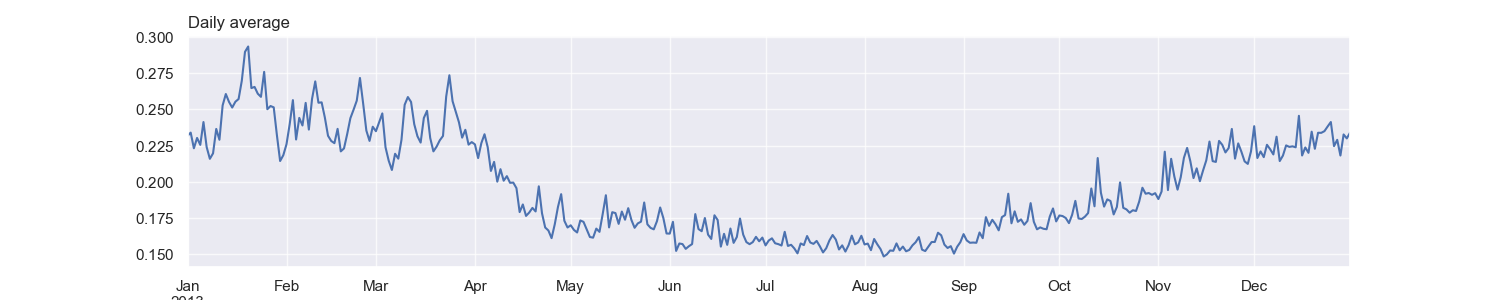

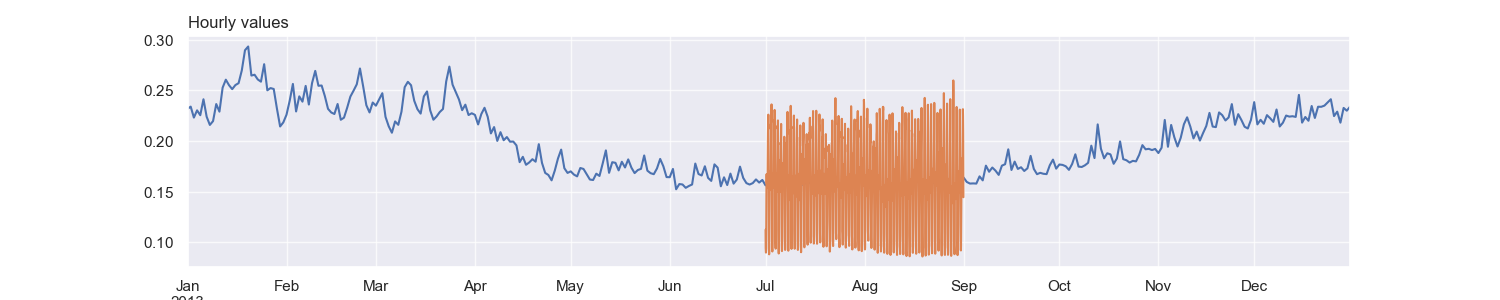

In [22]:
london_tou.mean(axis=1).rename('load').loc['2013'].resample('D').mean().plot(title='Daily average', figsize=(15,3))
plt.show()
london_tou.mean(axis=1).rename('load').loc['2013-07':'2013-08'].plot(title='Hourly values', figsize=(15,3))
plt.show()

In [23]:
df_dataset = london_tou.mean(axis=1).rename('load').to_frame().copy()


index_temp = df_dataset.index.copy()

df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset['load_shift24'] = df_dataset['load'].shift(24)
df_dataset['load_shift168'] = df_dataset['load'].shift(168)

df_dataset = df_dataset.merge(london_weather['temp'], left_index=True, right_index=True)
df_dataset['temp_roll24_mean'] = df_dataset['temp'].rolling(24).mean()

df_dataset = df_dataset.merge(df_holiday, on='date')
df_dataset = df_dataset.merge(df_holiday_encode, on='date')
#df_dataset = df_dataset.merge(all_trends_GB.reset_index(), on='date')

#df_dataset = df_dataset.drop('date',axis=1)
df_dataset.index = index_temp


df_dataset

,load,date,year,weekday,hour,timeofweek,load_shift24,load_shift168,temp,temp_roll24_mean,holiday_Name,holiday_Type,holiday_Name_encode,holiday_Type_encode
date,,,,,,,,,,,,,,
2011-11-23 09:00:00,0.180500,2011-11-23,2011,2,9.0,57.0,NaN,NaN,5.0,NaN,weekday,weekday,45,5
2011-11-23 10:00:00,0.088750,2011-11-23,2011,2,10.0,58.0,NaN,NaN,5.0,NaN,weekday,weekday,45,5
2011-11-23 11:00:00,0.101250,2011-11-23,2011,2,11.0,59.0,NaN,NaN,7.0,NaN,weekday,weekday,45,5
2011-11-23 12:00:00,0.162500,2011-11-23,2011,2,12.0,60.0,NaN,NaN,8.0,NaN,weekday,weekday,45,5
2011-11-23 13:00:00,0.149750,2011-11-23,2011,2,13.0,61.0,NaN,NaN,9.0,NaN,weekday,weekday,45,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,0.328569,2014-02-27,2014,3,20.0,92.0,0.339567,0.319700,8.0,8.583333,Maha Shivaratri,Hindu Holiday,22,2
2014-02-27 21:00:00,0.315401,2014-02-27,2014,3,21.0,93.0,0.307765,0.293022,6.0,8.500000,Maha Shivaratri,Hindu Holiday,22,2
2014-02-27 22:00:00,0.287290,2014-02-27,2014,3,22.0,94.0,0.274702,0.269723,6.0,8.458333,Maha Shivaratri,Hindu Holiday,22,2


## 1st model: temporal feature + weather feature

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: xlabel='timeofweek', ylabel='load'>

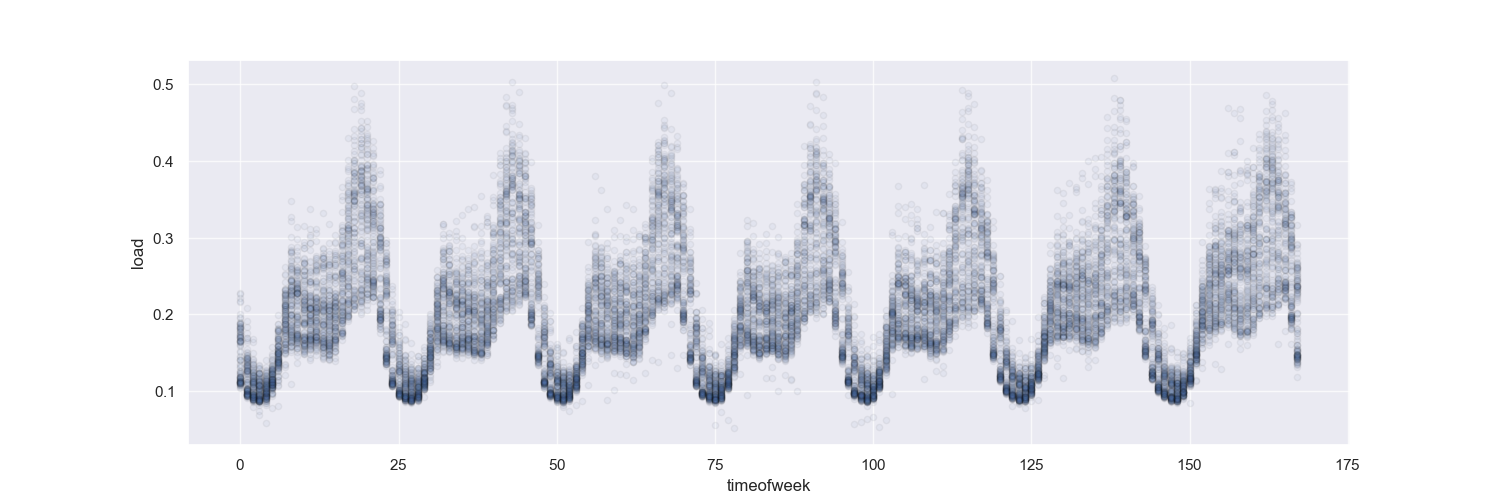

In [24]:
df_dataset.plot(kind='scatter',x='timeofweek',y='load', figsize=(15,5),alpha=0.05)

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_72664/1490947258.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_dataset.resample('D').mean().copy()


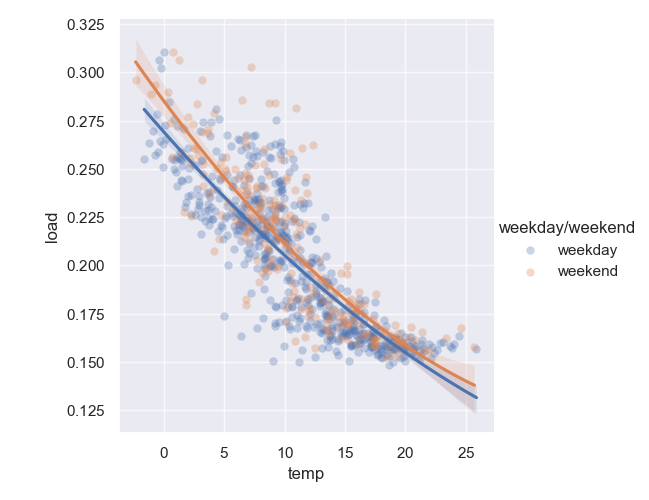

In [25]:
# Scatter plot for demand and outdoor temperature
df_plot = df_dataset.resample('D').mean().copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'

sns.lmplot(x='temp', y='load', hue="weekday/weekend",
           data=df_plot, order=2, scatter_kws={'alpha':0.3})

In [26]:
list_feat = ['weekday','hour','temp', 'load_shift168']

In [27]:
traindata = df_dataset.loc[:'2012'].copy()
testdata = df_dataset.loc['2013':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

## 2nd model: add calendar data

In [15]:
list_feat = ['weekday','hour','temp', 'temp_roll24_mean',
             'holiday_Name_encode','holiday_Type_encode']

Model: LGBM
R SQUARED: 0.8665
MAE: 0.019


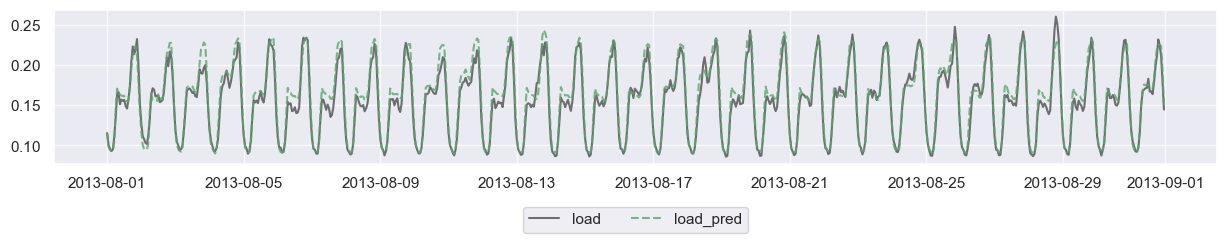

In [16]:
traindata = df_dataset.loc[:'2012'].copy()
testdata = df_dataset.loc['2013':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

## 3rd model: add lag features

In [17]:
list_feat = ['weekday','hour','temp', 'temp_roll24_mean',
             'holiday_Name_encode','holiday_Type_encode',
             'load_shift24', 'load_shift168']

Model: LGBM
R SQUARED: 0.9535
MAE: 0.011


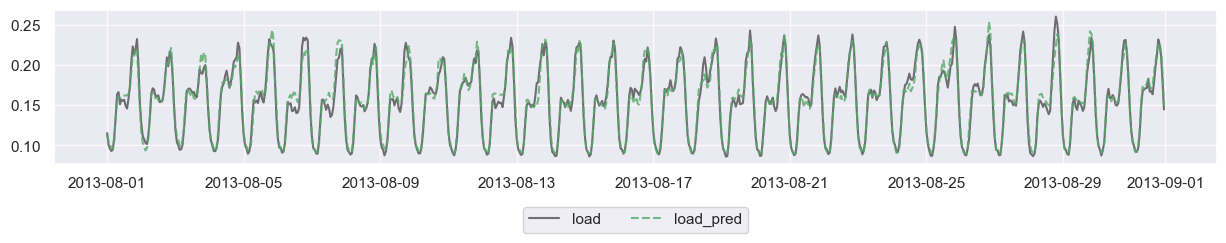

In [18]:
traindata = df_dataset.loc[:'2012'].copy()
testdata = df_dataset.loc['2013':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

## 4rd model: add google trends data

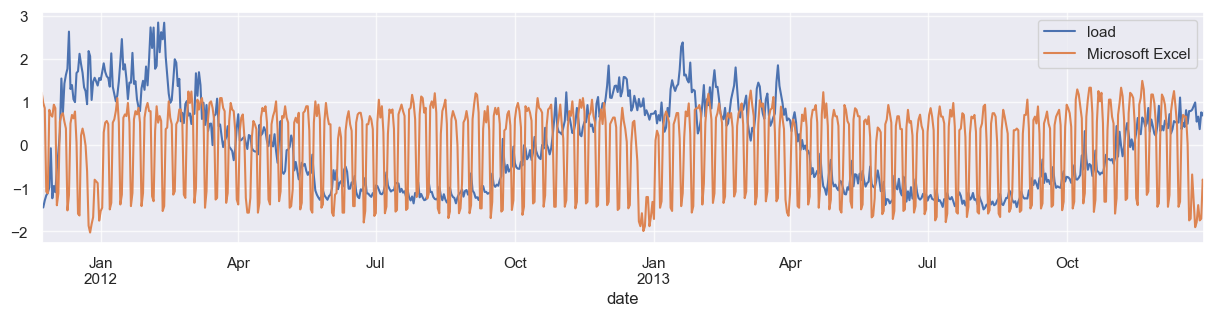

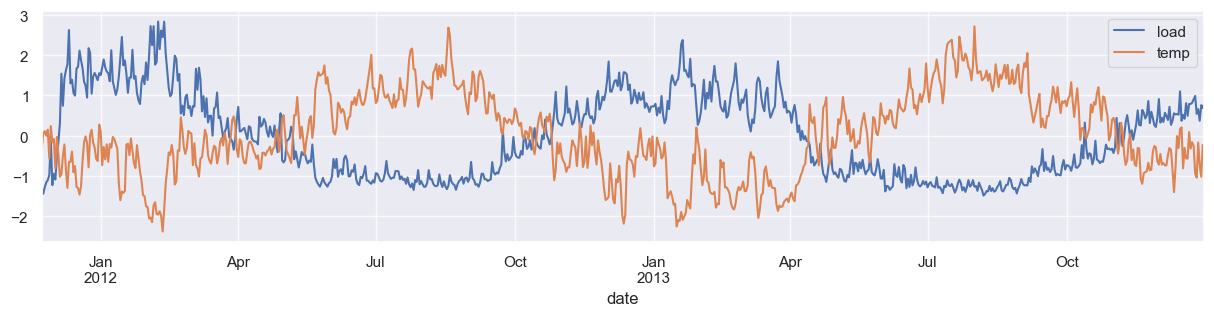

In [19]:
df_plot = df_dataset.resample('D').mean()
df_plot = (df_plot-df_plot.mean())/df_plot.std()
df_plot[['load','Microsoft Excel']].loc[:'2013'].plot(figsize=(15,3))
plt.show()
df_plot[['load','temp']].loc[:'2013'].plot(figsize=(15,3))
plt.show()

In [20]:
list_feat = ['weekday','hour','temp', 'temp_roll24_mean',
             'holiday_Name_encode','holiday_Type_encode',
             'load_shift24', 'load_shift168',
             'Microsoft Excel', 'Education']

Model: LGBM
R SQUARED: 0.9532
MAE: 0.0112


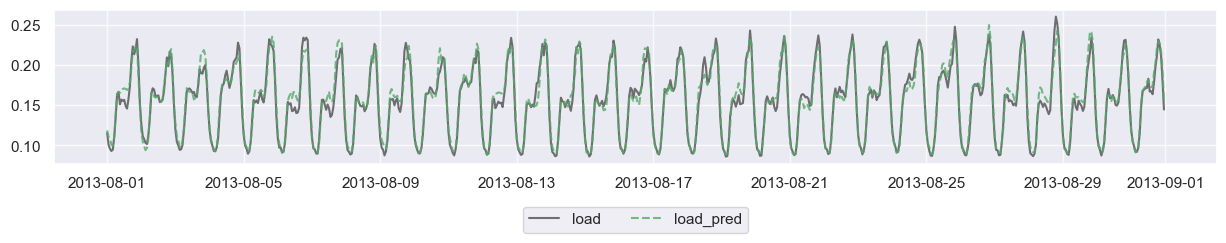

In [21]:
traindata = df_dataset.loc[:'2012'].copy()
testdata = df_dataset.loc['2013':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))